In [1]:
# importing rampy
import rampy as rp
# and for numpy we will respect the usual name:ß
import numpy as np
# for matplotlib
import matplotlib.pyplot as plt
from pydantic import BaseModel

# Experiment Subject 1

We performed OGTT on subject 1.

Here is the glucose concentration in blood during the 2 hour

| Time     | Concentration | filename |
|----------|---------------|----------|
| Predrink | 93            | pre      |
| 08:30    | 94            | 0        |
| 08:35    | 97            | 1        |
| 08:40    | 101           | 2        |
| 08:45    | 126           | 3        |
| 08:50    | 142           | 4        |
| 08:55    | 161           | 5        |
| 09:00    | 152           | 6        |
| 09:05    | 159           | 7        |
| 09:10    | 160           | 8        |
| 09:15    | 156           | 9        |
| 09:20    | 155           | 10       |
| 09:25    | 151           | 11       |
| 09:30    | 135           | 12       |
| 09:35    | 124           | 13       |
| 09:40    | 112           | 14       |
| 09:45    | 102           | 15       |
| 09:50    | 107           | 16       |
| 09:55    | 121           | 17       |
| 10:00    | 125           | 18       |
| 10:05    | 120           | 19       |
| 10:10    | 124           | 20       |
| 10:15    | 123           | 21       |
| 10:20    | 112           | 22       |
| 10:25    | 109           | 23       |
| 10:30    | 100           | 24       |

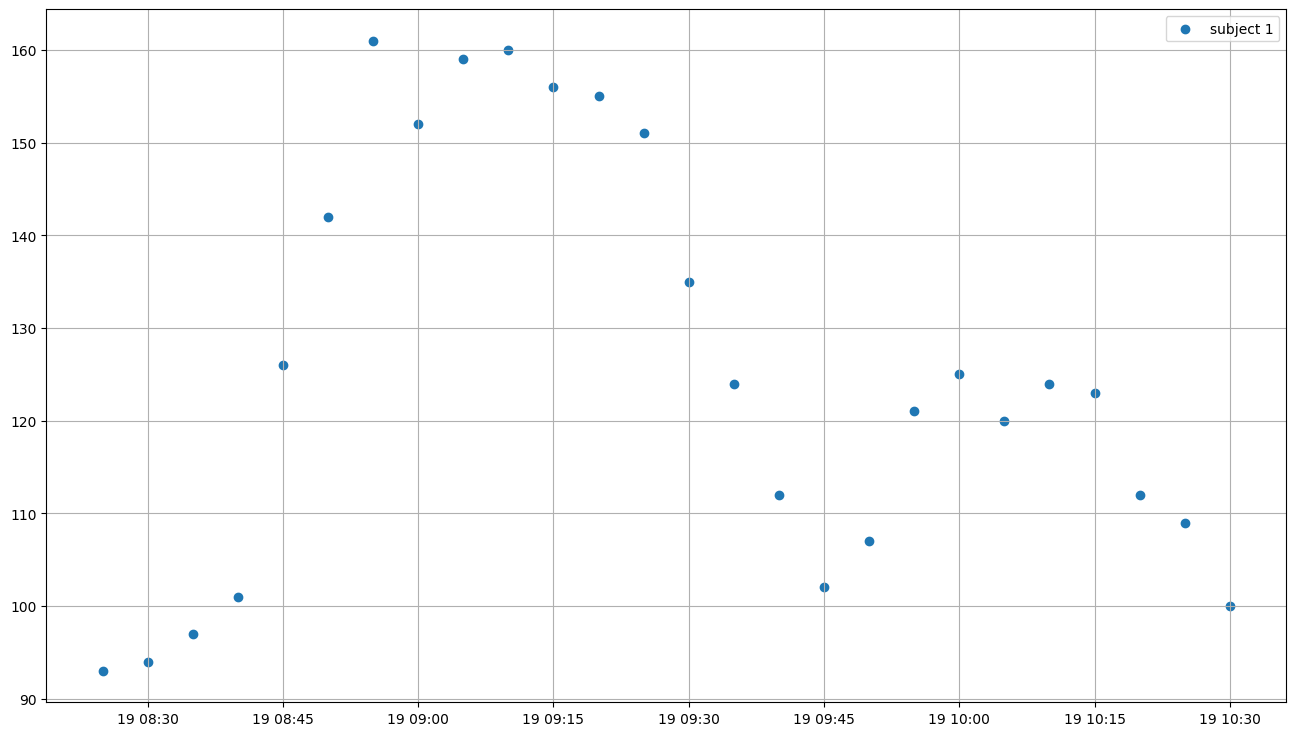

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the concentration over time
times = ["08:25","08:30","08:35","08:40","08:45","08:50","08:55","09:00","09:05","09:10","09:15","09:20","09:25","09:30","09:35","09:40","09:45","09:50","09:55","10:00","10:05","10:10","10:15","10:20","10:25","10:30"]
for idx,t in enumerate(times):
    times[idx] = f"2024-03-19T{t}"
times = np.array(times, dtype="datetime64")

glucoses = [93, 94,97,101,126,142,161,152,159,160,156,155,151,135,124,112,102,107,121,125,120,124,123,112,109,100]

fig, ax = plt.subplots(figsize=(16,9))
ax.scatter(times, glucoses, label="subject 1")
ax.grid()
ax.legend()
plt.show()

In [3]:
from typing import List
class XRange(BaseModel):
    lower_limit:float
    higher_limit:float

def _select_range(x_range:XRange, data:np.array) -> np.array:
    cond1 = data[:,0] > x_range.lower_limit
    cond2 = data[:,0] < x_range.higher_limit
    cond = cond1 & cond2
    data = data[cond].copy()
    return data

def _single_load_data(filename:str, x_range:XRange=None,  basepath:str="./data") -> np.array:
    # from glob import glob
    import os
    filepath = os.path.join(basepath, f"{filename}")
    if(os.path.exists(filepath) == False):
        raise FileExistsError(f"{filepath=} is not exists")
    spectrum = np.genfromtxt(filepath)
    # Flip X-axis
    spectrum = rp.flipsp(spectrum)
    if(x_range != None):
        assert isinstance(x_range, XRange), f"limit_x must be `XRange`"
        spectrum = _select_range(x_range=x_range, data=spectrum)
    return spectrum

def load_data(filenames:List[str], x_range:XRange=None, basepath:str="./data") -> np.array:
    import os
    spectrums = []
    for f in filenames:
        # print(f)
        spectrum = _single_load_data(filename=f, x_range=x_range, basepath=basepath)
        spectrums.append(spectrum)

    # avergae
    spectrums = np.array(spectrums)
    spectrums = spectrums.mean(axis=0)
    return spectrums

x_range = XRange(lower_limit=600, higher_limit=1500)
# spectrum = load_data("dark_600_785 nm_360 s_1_2024_02_22_19_30_02_01.txt", x_range=x_range)

In [4]:
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import savgol_filter, general_gaussian

def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def despike(y:np.array,window_size:int=20) -> np.array:
    ma = window_size//2
    threshold = 7 # binarization threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    # print(spikes.any())
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            y_out[i] = np.mean(y[we])
    return y_out


# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Parameters for this case:
lam = 10000000 # smoothness
p = 0.05 # asymmetry
# Baseline stimation function:
def baseline_als(y, lam, p, n_epoch=100) -> np.array:
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_epoch):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    corrected_y = y.copy() - z.copy()
    return corrected_y, z


In [5]:
from glob import glob 

files = ["predrink","0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22","23","24"]
spectrums = []
for f in files:
    f_list = glob(f'./data/{f}_*')
    # print(f_list)
    spectrum = load_data(filenames=f_list, x_range=x_range, basepath="")
    spectrums.append(spectrum)

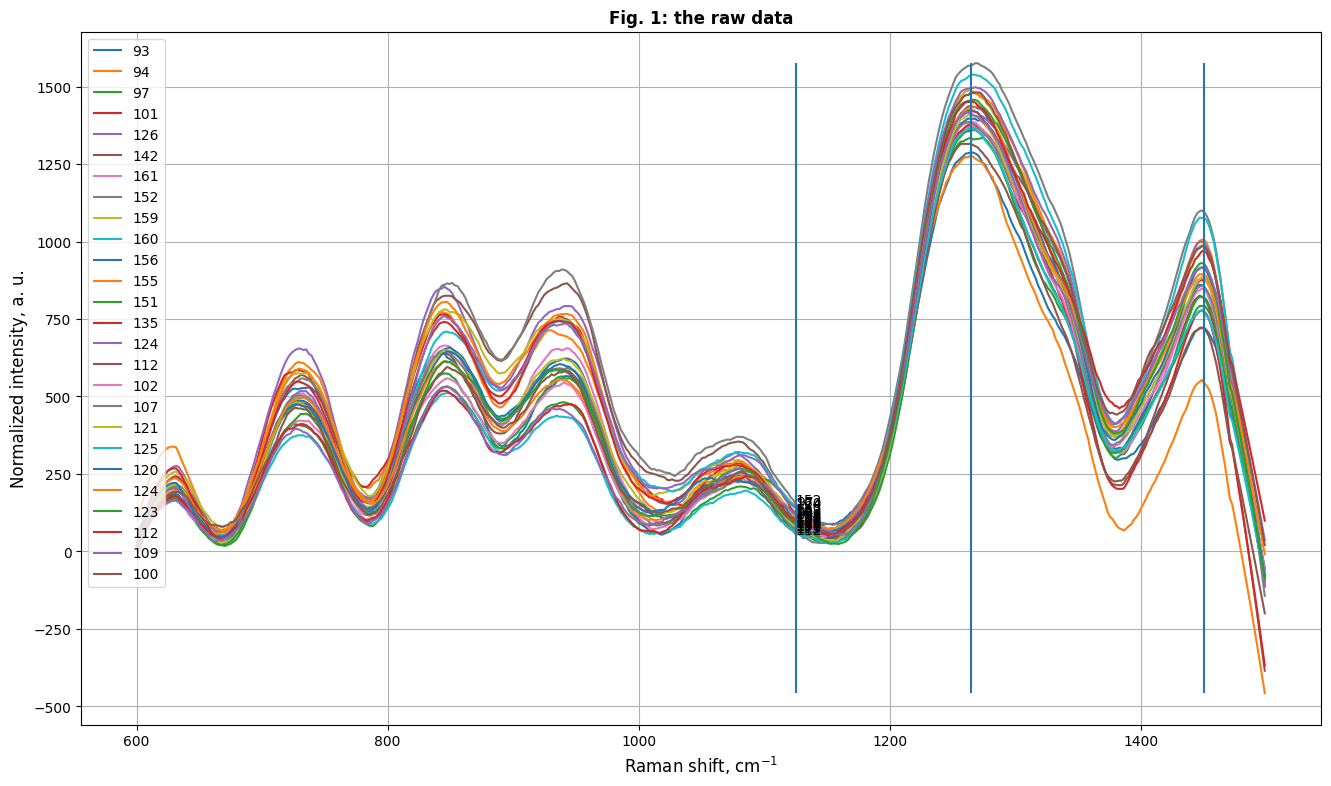

In [6]:
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf

# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)
    y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # print(y[:,0].shape)
    y = savgol_filter(y[:,0].copy(), window_length=30, polyorder=2, deriv=0)
    ax.plot(x,y,markersize=1, label=glucose)
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
#ax.set_ylim(ymax=-900, ymin=-1600)
#ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()

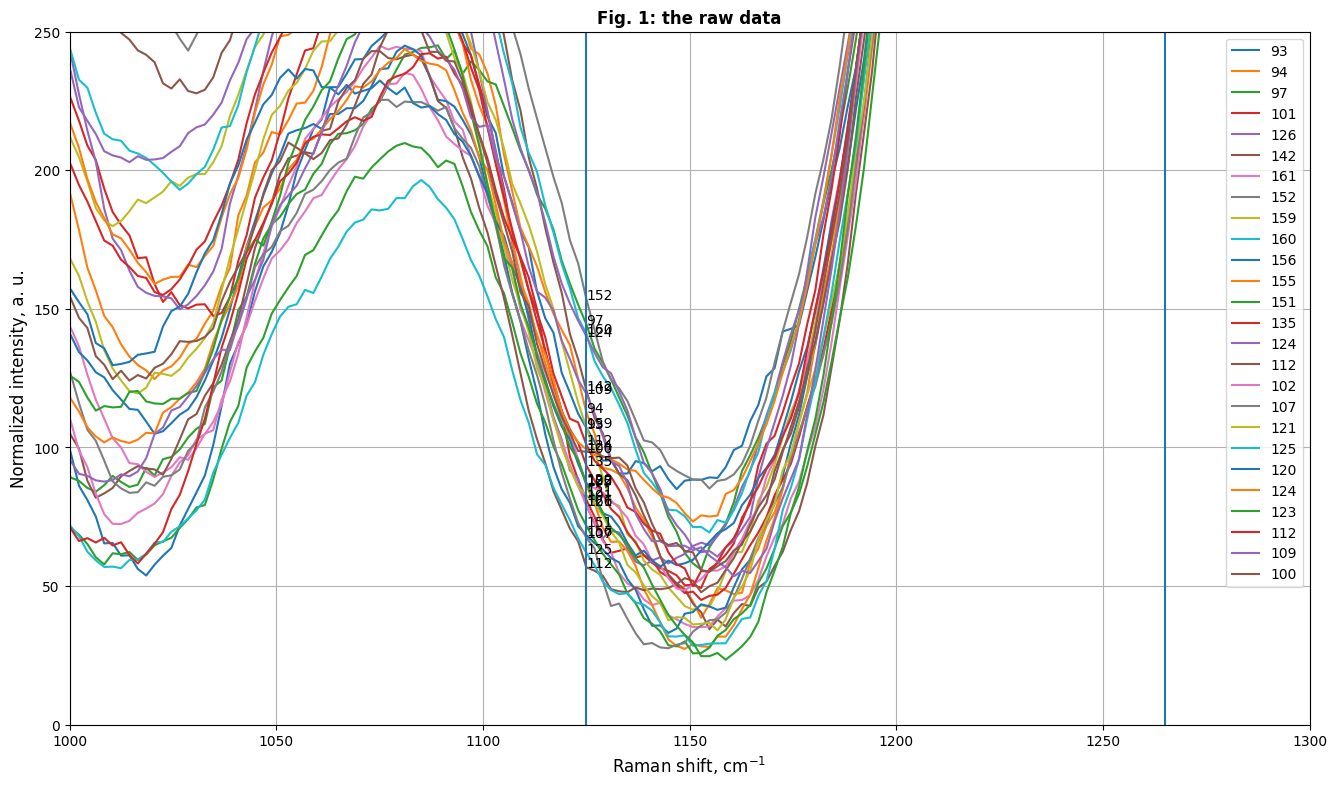

In [12]:
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf

# need to define some fitting regions for the spline
roi1 = np.array([[0, 1500]])
roi2 = np.array([[1245, 1285],[1430, 1470]])


for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    # We did not detect any spike
    y = despike(y, window_size=10)
    # y, baseline = baseline_als(y, lam=lam, p=p)
    y, base_poly = rp.baseline(x, y, roi1, 'rubberband', polynomial_order=2)
    y, base_poly = rp.baseline(x, y, roi2, 'rubberband', polynomial_order=2)
    # print(y[:,0].shape)
    y = savgol_filter(y[:,0].copy(), window_length=30, polyorder=2, deriv=0)
    ax.plot(x,y,markersize=1, label=glucose)
    txt_pos_y = y[(x > 1124) & (x < 1126)][0]
    txt_pos_x = 1125
    ax.text(x=txt_pos_x, y=txt_pos_y, s=str(glucose))
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])

    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()

ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
ax.vlines(x=1265, ymax=ymax, ymin=ymin)
ax.vlines(x=1450, ymax=ymax, ymin=ymin)
ax.set_ylim(ymax=250, ymin=0)
ax.set_xlim(xmax=1300, xmin=1000)
ax.grid()
ax.legend()
plt.show()

In [8]:
x[(x > 1124) & (x < 1126)][0]

1125.01

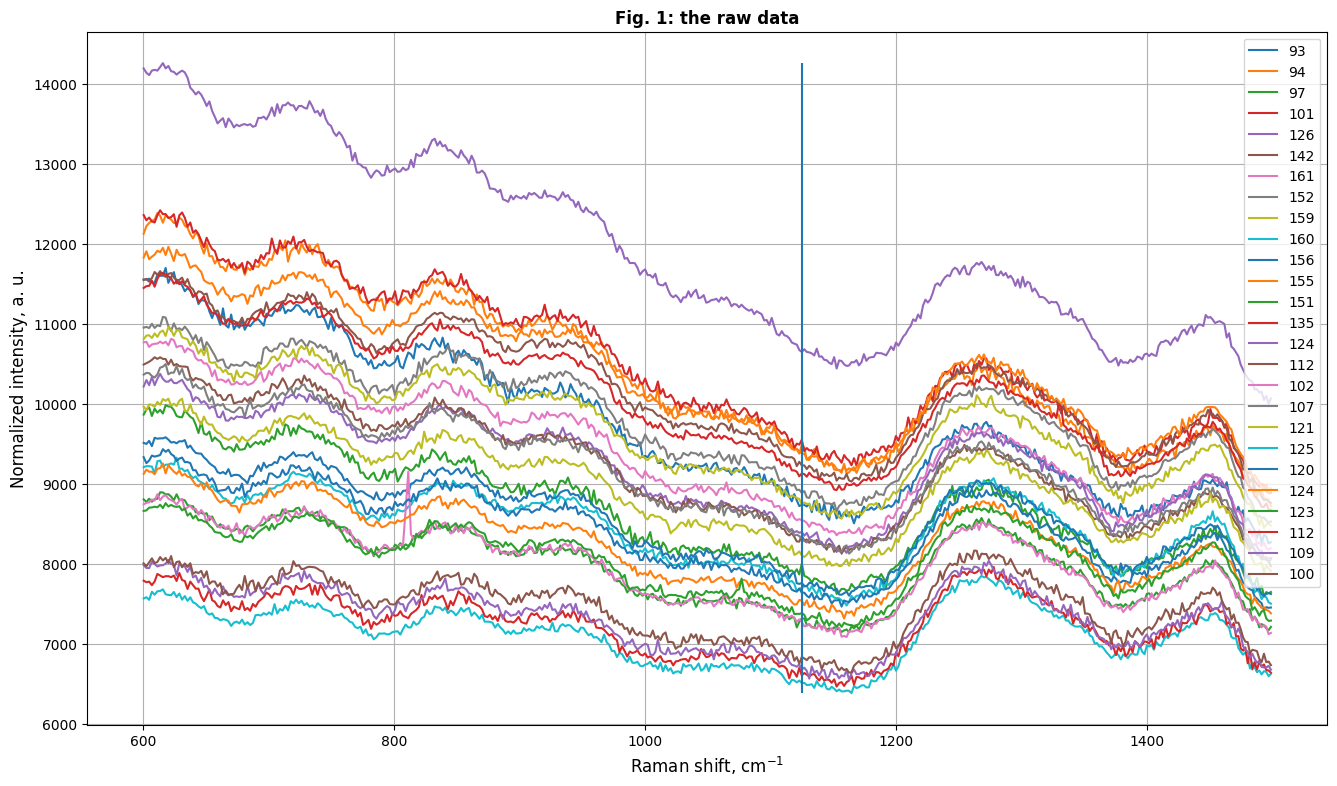

In [9]:
fig,ax = plt.subplots(figsize=(16,9))

ymax = -1 * np.inf
ymin = np.inf
for glucose,spectrum in zip(glucoses, spectrums):
    x = spectrum[:,0].copy()
    y = spectrum[:,1].copy()
    ax.plot(x,y,markersize=1, label=glucose)
    # spectrum[:,1] = rp.smooth(spectrum[:,0],spectrum[:,1], method='savgol', window_length=15, polyorder=2)
    # ax.plot(spectrum[:,0],spectrum[:,1],markersize=1, label=glucose, c=color_map[glucose])
    if y.max() > ymax: ymax = y.max()
    if y.min() < ymin: ymin = y.min()


ax.set_xlabel("Raman shift, cm$^{-1}$", fontsize = 12)
ax.set_ylabel("Normalized intensity, a. u.", fontsize = 12)
ax.set_title("Fig. 1: the raw data",fontsize = 12,fontweight="bold")
ax.vlines(x=1125, ymax=ymax, ymin=ymin)
# ax.set_ylim(ymax=3200, ymin=2700)
# ax.set_xlim(xmax=1000, xmin=1300)
ax.grid()
ax.legend()
plt.show()